In [1]:
import numpy as np
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
from GISio import shp2df
from descartes import PolygonPatch

% matplotlib inline

### `shapely`
#### make some arbitrary polygons
test them for intersection; demonstrate some other methods
see: http://toblerity.org/shapely/manual.html#predicates-and-relationships


In [2]:
p1 = Polygon(((0, 0), (0, 1), (1, 1), (1, 0)))
p2 = Polygon(((0.5, 0.5), (0.5, 1.5), (1.5, 1.5), (1.5, 0.5), (0.5, 0.5)))
p1.intersects(p2)

True

In [3]:
p1.within(p2)

False

In [4]:
p1.touches(p2)

False

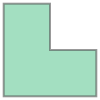

In [5]:
dif = p1.difference(p2)
dif

In [6]:
un = p1.union(p2)
un

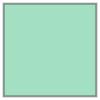

In [7]:
ints = p1.intersection(p2)
ints

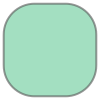

In [8]:
buf = ints.buffer(0.5, )
buf

#### make a quick and dirty plot that illustrates the exterior rings of the shapes together

In [9]:
fig, ax = plt.subplots()
plt.plot(*zip(*p1.exterior.coords), label='p1')
plt.plot(*zip(*p2.exterior.coords), color='r', label='p2')
plt.plot(*zip(*dif.exterior.coords), color='g', label='diff')
plt.plot(*zip(*ints.exterior.coords), color='k', label='ints')
plt.plot(*zip(*buf.exterior.coords), color='k', label='buf')
ax.set_xlim(-1, 2)
ax.set_ylim(-1, 2)
plt.legend(loc=2)

#### read in a shapefile

In [10]:
shapefile = 'data/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA.shp'
df = shp2df(shapefile)


reading data/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA.shp...
--> building dataframe... (may take a while for large shapefiles)


### `descartes`
#### make a patch (plottable by `pyplot`) of a single geometry using `PolygonPatch`

In [11]:
PolygonPatch(df.geometry[0])

In [12]:
from matplotlib.collections import PatchCollection

### make a patch collection of all the geometries

In [13]:
list(df.geometry[0].exterior.coords)

[(-117.1935499999999, 33.74306900000005),
 (-117.1935729999999, 33.74198700000005),
 (-117.19369999999992, 33.73596500000008),
 (-117.18936799999994, 33.73584000000005),
 (-117.18935499999992, 33.72862400000008),
 (-117.18935399999992, 33.72801800000008),
 (-117.18925499999995, 33.72163400000005),
 (-117.18921699999993, 33.719152000000065),
 (-117.18921699999993, 33.71860200000009),
 (-117.18910699999992, 33.717250000000035),
 (-117.18907999999993, 33.715738000000044),
 (-117.18896999999993, 33.71498200000008),
 (-117.18896999999993, 33.71418100000005),
 (-117.18866899999995, 33.712829000000056),
 (-117.18855899999994, 33.71266900000006),
 (-117.18844899999993, 33.711959000000036),
 (-117.18817499999994, 33.71113400000007),
 (-117.1879449999999, 33.71056900000008),
 (-117.18770899999993, 33.709989000000064),
 (-117.18757899999991, 33.709771000000046),
 (-117.1873359999999, 33.70936400000005),
 (-117.18714099999994, 33.709039000000075),
 (-117.18696899999992, 33.70875200000006),
 (-117.

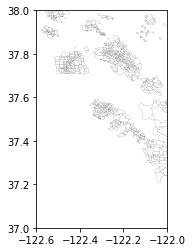

In [22]:
fig, ax = plt.subplots()
cl = PatchCollection([PolygonPatch(p) for p in df.geometry],
                             facecolor='w', edgecolor='k', linewidth=0.1)
ax.add_collection(cl)
ax.set_xlim(-122.6, -122)
ax.set_ylim(37, 38)
ax.set_aspect(1)

### `pyproj`

In [15]:
import pyproj
from functools import partial
from shapely.ops import transform

#### proj4 strings for source and destination coordinate systems

In [16]:
projection1 = '+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs'
projection2 = '+init=epsg:26916'

#### make `pyproj.Proj` objects

In [17]:
pr1 = pyproj.Proj(projection1, errcheck=True, preserve_units=True)
pr2 = pyproj.Proj(projection2, errcheck=True, preserve_units=True)

#### transform of a single point using pyproj

In [18]:
pyproj.transform(pr1, pr2, -89, 43)

(336980.9299175093, 4762755.641571694)

#### partial function for repeated application of the transform
the other two arguments are the x and y coordinates

In [19]:
projectf = partial(pyproj.transform, pr1, pr2)
projectf

functools.partial(<function transform at 0x11c3eed90>, <pyproj.Proj object at 0x11a3b5768>, <pyproj.Proj object at 0x11a3b57c8>)

#### `shapely.ops.transform` takes two arguments  
1) a function such as the one above that can transform a coorindate pair  
2) a shapely geometry object

It then applies the transformation to each coordinate represented in the geometry object. We build on this further by looping over the geometry objects in a list comprehension.

In [20]:
geomsutm = [transform(projectf, g) for g in df.geometry]

### Reprojection using the `GIS_utils` `projectdf` macro

In [21]:
from GISops import project

In [22]:
geoms = project(df.geometry.values, projection1, projection2)

In [23]:
from GISio import shp2df, df2shp

### Reprojecting a shapefile using `projectdf`

In [24]:
df = shp2df(shapefile)
geoms = project(df.geometry.values, projection1, projection2)
df['geometry'] = geoms
df2shp(df, 'data/scratch.shp', proj4=projection2)


reading data/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA.shp...
--> building dataframe... (may take a while for large shapefiles)
writing data/scratch.shp...
